<a href="https://colab.research.google.com/github/agranan/SOC2024/blob/main/DDPMImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import glob
import os
from PIL import Image
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision
import argparse
import yaml
from torchvision.utils import make_grid


In [2]:
import numpy as np

In [21]:
class LinearNoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim = 0).to(device)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod).to(device)
        self.one_minus_alpha_cum_prod = torch.sqrt(1. - self.alpha_cum_prod).to(device)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod).to(device)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise

    def sample_prev_timestep(self, xt, noise_pred, t):
        x0 = (xt - (self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)) / self.sqrt_alpha_cum_prod[t]
        x0 = torch.clamp(x0, -1., 1.)
        mean = xt - ((self.betas[t] * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod[t]))
        mean = mean / torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod[t - 1]) / (1. - self.alpha_cum_prod[t])
            variance = variance * self.betas[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

In [4]:
def get_time_embedding(time_steps, t_emb_dim):
    factor = 10000 ** ((torch.arange(
        start = 0., end = t_emb_dim // 2, device = time_steps.device) / (t_emb_dim // 2)
    ))
    t_emb = time_steps[:, None].repeat(1, t_emb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim = -1)
    return t_emb


In [5]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, down_sample, num_heads):
        super().__init__()
        self.down_sample = down_sample
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        )
        self.t_emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, out_channels)
        )
        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        )
        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
        self.residual_input_conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()

    def forward(self, x, t_emb):
        out = x;

        resnet_input = out
        out = self.resnet_conv_first(out)
        out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        out= self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)

        batch_size, channels, h, w = out.shape
        in_attn = out.reshape(batch_size, channels, h * w)
        in_attn = self.attention_norm(in_attn)
        in_attn = in_attn.transpose(1, 2)
        out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        out = out + out_attn

        out = self.down_sample_conv(out)
        return out

In [6]:
class MidBlock(nn.Module):
     def __init__(self, in_channels, out_channels, t_emb_dim, num_heads):
        super().__init__()
        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            ),
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            )
        ])
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            ),
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
        ])
        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            ),
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
            ),
        ])
        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
        self.residual_input_conv = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size = 1),
            nn.Conv2d(out_channels, out_channels, kernel_size = 1)
        ])

     def forward(self, x, t_emb):
        out = x

        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)

        batch_size, channels, h, w = out.shape
        in_attn = out.reshape(batch_size, channels, h * w)
        in_attn = self.attention_norm(in_attn)
        in_attn = in_attn.transpose(1, 2)
        out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        out = out + out_attn

        resnet_input = out
        out = self.resnet_conv_first[1](out)
        out = out + self.t_emb_layers[1](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[1](out)
        out = out + self.residual_input_conv[1](resnet_input)

        return out

In [7]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample, num_heads):
        super().__init__()
        self.up_sample = up_sample
        self.resnet_conv_first = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        )
        self.t_emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, out_channels)
        )
        self.resnet_conv_second = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        )

        self.attention_norm = nn.GroupNorm(8, out_channels)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, batch_first = True)
        self.residual_input_conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size = 4,
                                                 stride = 2, padding = 1) if self.up_sample else nn.Identity()

    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim = 1)


        out = x
        resnet_input = out
        out = self.resnet_conv_first(out)
        out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        out = self.resnet_conv_second(out)
        out = out + self.residual_input_conv(resnet_input)

        batch_size, channels, h, w = out.shape
        in_attn = out.reshape(batch_size, channels, h * w)
        in_attn = self.attention_norm(in_attn)
        in_attn = in_attn.transpose(1, 2)
        out_attn, _ = self.attention(in_attn, in_attn, in_attn)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        out = out + out_attn

        return out


In [8]:
class Unet(nn.Module):
    def __init__(self, model_config):
        super().__init__()
        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = [True, True, False]

        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size = 3, padding = 1)

        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i + 1], self.t_emb_dim,
                                        down_sample = self.down_sample[i], num_heads = 4))

        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1], self.t_emb_dim, num_heads = 4))

        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels) - 1)):
            self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i - 1] if i!= 0 else 16,
                                    self.t_emb_dim, up_sample = self.down_sample[i], num_heads = 4))

        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size = 3, padding = 1)

    def forward(self, x, t):
        out = self.conv_in(x)
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        down_outs = []
        for down in self.downs:
            # print(out.shape)
            down_outs.append(out)
            out = down(out, t_emb)

        for mid in self.mids:
            # print(out.shape)
            out = mid(out, t_emb)

        for up in self.ups:
            down_out = down_outs.pop()
            # print(out.shape, down_out.shape)
            out = up(out, down_out, t_emb)
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        return out

In [9]:
class MnistDataset(Dataset):

    def __init__(self, split, im_path, im_ext = 'png'):
        self.split = split
        self.im_ext = im_ext
        self.images, self.labels = self.load_images(im_path)

    def load_images(self, im_path):
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        ims = []
        labels = []
        for d_name in tqdm(os.listdir(im_path)):
            for fname in glob.glob(os.path.join(im_path, d_name, '*.{}'.format(self.im_ext))):
                ims.append(fname)
                labels.append(int(d_name))
        print('Found {} images for split {}'.format(len(ims), self.split))
        return ims, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        im = Image.open(self.images[index])
        im_tensor = torchvision.transforms.ToTensor()(im)

        im_tensor = (2 * im_tensor) - 1
        return im_tensor

In [16]:
import yaml
import argparse
from torch.optim import Adam
import os
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
from torchvision import transforms

In [18]:
import torchvision.datasets as datasets

mnist_trainset = datasets.MNIST(root='/content/drive/MyDrive/PracticeColab/Data', train=True, download=True, transform=transforms.ToTensor())


In [19]:
mnist_testset = datasets.MNIST(root='/content/drive/MyDrive/PracticeColab/Data', train=False, download=True, transform=transforms.ToTensor())


In [20]:
len(mnist_trainset)

60000

In [22]:
def train(args):
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)

    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    model_config = config['model_params']
    train_config = config['train_params']

    scheduler = LinearNoiseScheduler(num_timesteps = diffusion_config['num_timesteps'],
                                     beta_start = diffusion_config['beta_start'],
                                     beta_end = diffusion_config['beta_end'])

    # mnist = MnistDataset('train', im_path = dataset_config['im_path'])
    mnist_loader = DataLoader(mnist_trainset, batch_size = train_config['batch_size'], shuffle = True, num_workers = 2)

    model = Unet(model_config).to(device)
    model.train()

    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])

    # if os.path.exists(os.path.join(train_config['task_name'], train_config['ckpt_name'])):
    #     print('Loading checkpoint as found one')
    #     model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
    #                                                   train_config['ckpt_name']), map_location = device))

    num_epochs = train_config['num_epochs']
    optimizer = Adam(model.parameters(), lr = train_config['lr'])
    criterion = torch.nn.MSELoss()

    for epoch_idx in range(num_epochs):
        losses = []
        for i, (im, labels) in enumerate(mnist_loader):
            optimizer.zero_grad()
            im = im.float().to(device)

            noise = torch.randn_like(im).to(device)

            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)

            noisy_im = scheduler.add_noise(im, noise, t)
            noise_pred = model(noisy_im, t)

            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        print('Finished epoch: {} | Loss : {:.4f}'.format(
            epoch_idx + 1,
            np.mean(losses),
        ))
        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['ckpt_name']))
    print('Done Training...')

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description = "Arguments for ddpm training")
    parser.add_argument('--config', dest = 'config_path',
                        default = '/content/drive/MyDrive/PracticeColab/config/default.yaml', type = str)
    args = parser.parse_args(args = [])
    train(args)

{'dataset_params': {'im_path': '/content/drive/MyDrive/PracticeColab/Data'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model_params': {'im_channels': 1, 'im_size': 28, 'down_channels': [32, 64, 128, 256], 'mid_channels': [256, 256, 128], 'down_sample': [True, True, False], 'time_emb_dim': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'num_heads': 4}, 'train_params': {'task_name': '/content/drive/MyDrive/PracticeColab/DDPM/default', 'batch_size': 64, 'num_epochs': 7, 'num_samples': 100, 'num_grid_rows': 10, 'lr': 0.0001, 'ckpt_name': 'ddpm_ckpt.pth'}}
Finished epoch: 1 | Loss : 0.0768
Finished epoch: 2 | Loss : 0.0252
Finished epoch: 3 | Loss : 0.0215
Finished epoch: 4 | Loss : 0.0198
Finished epoch: 5 | Loss : 0.0187
Finished epoch: 6 | Loss : 0.0180
Finished epoch: 7 | Loss : 0.0175
Done Training...


In [23]:
def sample(model, scheduler, train_config, model_config, diffusion_config):
    xt = torch.randn((train_config['num_samples'],
                      model_config['im_channels'],
                      model_config['im_size'],
                      model_config['im_size'])).to(device)

    for i in tqdm(reversed(range(diffusion_config['num_timesteps']))):
        noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))

        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))

        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow = train_config['num_grid_rows'])
        img = torchvision.transforms.ToPILImage()(grid)
        if not os.path.exists(os.path.join(train_config['task_name'], 'samples')):
            os.mkdir(os.path.join(train_config['task_name'], 'samples'))
        img.save(os.path.join(train_config['task_name'], 'samples', 'x0_{}.png'.format(i)))
        img.close()



In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [25]:
def infer(args):
    with open(args.config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)
    print(config)

    diffusion_config = config['diffusion_params']
    model_config = config['model_params']
    train_config = config['train_params']

    model = Unet(model_config).to(device)
    model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                  train_config['ckpt_name']), map_location = device))
    model.eval()

    scheduler = LinearNoiseScheduler(num_timesteps = diffusion_config['num_timesteps'],
                                     beta_start = diffusion_config['beta_start'],
                                     beta_end = diffusion_config['beta_end'])
    with torch.no_grad():
        sample(model, scheduler, train_config, model_config, diffusion_config)

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description = 'Arguments for ddpm image generation')
    parser.add_argument('--config', dest = 'config_path',
                        default = '/content/drive/MyDrive/PracticeColab/config/default.yaml', type = str)
    args = parser.parse_args(args = [])
    infer(args)

{'dataset_params': {'im_path': '/content/drive/MyDrive/PracticeColab/Data'}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model_params': {'im_channels': 1, 'im_size': 28, 'down_channels': [32, 64, 128, 256], 'mid_channels': [256, 256, 128], 'down_sample': [True, True, False], 'time_emb_dim': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'num_heads': 4}, 'train_params': {'task_name': '/content/drive/MyDrive/PracticeColab/DDPM/default', 'batch_size': 64, 'num_epochs': 7, 'num_samples': 100, 'num_grid_rows': 10, 'lr': 0.0001, 'ckpt_name': 'ddpm_ckpt.pth'}}


1000it [02:16,  7.33it/s]


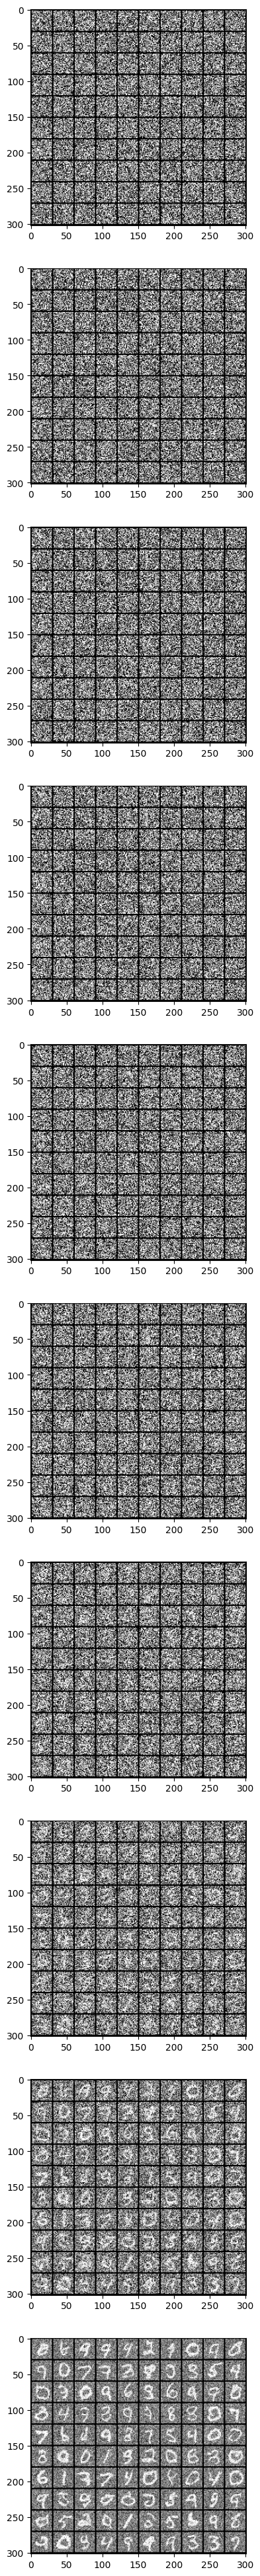

In [41]:
import matplotlib.pyplot as plt

# rows, cols = 10, 1
# plt.subplot(rows, cols, 1)
fig = plt.figure(figsize=(50, 50))
columns = 1
rows = 10
count = 999
for i in range(1, columns*rows +1):
    img = plt.imread('/content/drive/MyDrive/PracticeColab/DDPM/default/samples/x0_' + str(count) + '.png')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    count = count - 100

# plt.imshow(plt.imread('/content/drive/MyDrive/PracticeColab/DDPM/default/samples/x0_999.png'))
# plt.imshow(plt.imread('/content/drive/MyDrive/PracticeColab/DDPM/default/samples/x0_899.png'))

plt.show()

Final output = 


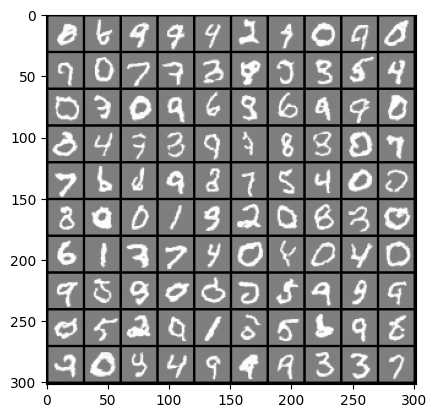

In [42]:
print("Final output = ")
plt.imshow(plt.imread('/content/drive/MyDrive/PracticeColab/DDPM/default/samples/x0_0.png'))